## Import libraries

In [1]:
# standard setup
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
import time

# useful helper function
from helpers import imshow

## Adding Dense Optical Flow on Video Frame

In [2]:
# parameters for farneback optical flow
fb_params = dict( pyr_scale = 0.5, 
                  levels = 3, 
                  winsize = 5, 
                  iterations = 3, 
                  poly_n = 5,
                  poly_sigma = 1.2, 
                  flags = 0 )

In [7]:
def initializeCamera(w):
    '''
    @w: width of the video frame
    @returns: camera object
    '''
    camera = cv2.VideoCapture(1)
    camera.set(cv2.CAP_PROP_FRAME_WIDTH, w) 
    camera.set(cv2.CAP_PROP_FRAME_HEIGHT, w * 3/4) 
    camera.set(cv2.CAP_PROP_EXPOSURE,-4) 
    return camera

In [8]:
def draw_motion_field(u, v, scale, stride, color=(0, 255, 0)):
    """Draws motion fields given the displacements in X and Y directions.
    
    """
    img_out = np.zeros((v.shape[0], u.shape[1], 3), dtype=np.uint8)

    for y in range(0,v.shape[0],stride):
        for x in range(0,u.shape[1],stride):
            cv2.line(img_out, (x, y), (x + int(u[y, x] * scale), y + int(v[y, x] * scale)), color, 1)
            cv2.circle(img_out, (x + int(u[y, x] * scale), y + int(v[y, x] * scale)), 1, color, 1)
            
    return img_out

In [9]:
def draw_motion_field_on_frame(frame, u, v, scale, stride, color=(0, 0, 0)):
    """Draws motion fields given the displacements in X and Y directions.
    
    """
    img_out = frame.copy()

    for y in range(5,v.shape[0],stride):
        for x in range(5,u.shape[1],stride):
            cv2.line(img_out, (x, y), (x + int(u[y, x] * scale), y + int(v[y, x] * scale)), color, 2)
            cv2.circle(img_out, (x + int(u[y, x] * scale), y + int(v[y, x] * scale)), 3, color, 3)
            
    return img_out

In [13]:
from IPython.display import clear_output

# Initialize camera
camera = initializeCamera(640)

# Flip frame
ret, prev_frame = camera.read()
prev_frame = cv2.flip(prev_frame, 1)
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

while True:
    clear_output(True)

    # Get current frame at flip it
    ret, next_frame = camera.read()
    next_frame = cv2.flip(next_frame, 1)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Calculate the dense optical flow
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, **fb_params)
    
    # Obtain the flow magnitude and direction angle
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    
    # Add vector field to a video frame
    field_img = draw_motion_field_on_frame(next_frame, flow[...,0], flow[...,1], scale=2, stride=50)
        
    cv2.imshow('Frame', next_frame)
    cv2.imshow('Field', field_img)
    
    prev_gray = next_gray
    
    if cv2.waitKey(5) == 27:
        break      
        
cv2.destroyAllWindows()
camera.release()
cv2.waitKey(1) # extra waitKey sometimes needed to close camera window

-1

## Find General Direction and Magnitue

In [14]:
# Helper function to find magnitude of the vector
def get_mag(dx, dy):
    return np.linalg.norm([dx, dy])


# Helper function to find angle of the vector
def get_angle(dx, dy):
    x_direction = [1, 0]
    v = [dx,dy] / np.linalg.norm([dx, dy])
    cos_theta = np.dot(v, x_direction) 
    orientation = np.cross(x_direction, v)
    if orientation >= 0:
        angle = np.arccos(cos_theta)*(180/np.pi)
    else:
        angle = 360 - np.arccos(cos_theta)*(180/np.pi)
    return angle

In [57]:
def average_displacement(frame, u, v, scale, stride, color=(0, 0, 0)):
    img_out = frame.copy()

    mag_ave = 0
    ang_ave = 0
    
    # angles[0] = 0
    # angles[1] = 90
    # angles[2] = 180
    # angles[3] = 270
    angles = np.zeros(4)
    magnitudes = np.zeros(4)
    
    directions = ["RIGHT", "DOWN", "LEFT", "UP"]
    
    for y in range(0,u.shape[0],stride):
        for x in range(0,u.shape[1],stride):
            dx, dy = u[y, x], v[y, x]
            mag = get_mag(dx, dy)
            ang = get_angle(dx, dy)
              
            if mag > 50:
                if ang>=315 or ang<45:
                    angles[0] += 1
                    magnitudes[0] += 1
                elif 45 <= ang < 135:
                    angles[1] += 1
                    magnitudes[1] += 1
                elif 135 <= ang < 225:
                    angles[2] += 1
                    magnitudes[2] += 1
                elif 225 <= ang < 315:
                    angles[3] += 1
                    magnitudes[3] += 1
            cv2.line(img_out, (x, y), (x + int(dx * scale), y + int(dy * scale)), color, 2)
            cv2.circle(img_out, (x + int(dx * scale), y + int(dy * scale)), 3, color, 3) 
                

    if np.sum(angles) >= 0:
        print np.max(angles), directions[np.argmax(angles)]
#         print np.argmax(angles)        
        if np.max(angles) >= 60:

            print directions[np.argmax(angles)]

    return img_out
    

In [62]:
### from IPython.display import clear_output

# Initialize camera
camera = initializeCamera(640)

# Flip frame
ret, prev_frame = camera.read()
prev_frame = cv2.flip(prev_frame, 1)
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

while True:
    clear_output(True)

    # Get current frame at flip it
    ret, next_frame = camera.read()
    next_frame = cv2.flip(next_frame, 1)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

    # Calculate the dense optical flow
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, **fb_params)
    
    # Obtain the flow magnitude and direction angle
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    
#     print mag.shape
#     print "Magnitude", mag[240,320]
#     print "Direction", ang[240,320]*180%360
#     print "Direction", ang[200,300]*180%360
#     print "Direction", ang[100,200]*180%360
    
    
    # Add vector field to a video frame
    field_img = average_displacement(next_frame, flow[...,0], flow[...,1], scale=2, stride=40)
    
    cv2.imshow('Frame', next_frame)
    cv2.imshow('Field', field_img)
    
    prev_gray = next_gray
    
    if cv2.waitKey(5) == 27:
        break      
        
cv2.destroyAllWindows()
camera.release()
cv2.waitKey(1) # extra waitKey sometimes needed to close camera window

2.0 RIGHT


-1

## Recognize Swiping gestures

In [63]:
# Helper function to find magnitude of the vector
def get_mag(dx, dy):
    return np.linalg.norm([dx, dy])


# Helper function to find angle of the vector
def get_angle(dx, dy):
    x_direction = [1, 0]
    v = [dx,dy] / np.linalg.norm([dx, dy])
    cos_theta = np.dot(v, x_direction) 
    orientation = np.cross(x_direction, v)
    if orientation >= 0:
        angle = np.arccos(cos_theta)*(180/np.pi)
    else:
        angle = 360 - np.arccos(cos_theta)*(180/np.pi)
    return angle

In [103]:
def average_displacement(frame, u, v, scale, stride, color=(0, 0, 0)):
    img_out = frame.copy()

    mag_ave = 0
    ang_ave = 0
    
    # angles[0] = 0
    # angles[1] = 90
    # angles[2] = 180
    # angles[3] = 270
    angles = np.zeros(2)
    magnitudes = np.zeros(2)
    
    directions = ["RIGHT","LEFT"]
    
    for y in range(25,u.shape[0],stride/4):
        for x in range(15,u.shape[1],stride):
            dx, dy = u[y, x], v[y, x]
            mag = get_mag(dx, dy)
            ang = get_angle(dx, dy)
              
            if mag > 350:
                if ang>=270 or ang<90:
                    angles[0] += 1
                    magnitudes[0] += 1
                elif 90 <= ang < 270:
                    angles[1] += 1
                    magnitudes[1] += 1
              
            cv2.line(img_out, (x, y), (x + int(dx * scale), y + int(dy * scale)), color, 2)
            cv2.circle(img_out, (x + int(dx * scale), y + int(dy * scale)), 3, color, 3) 
                

    if np.sum(angles) > 0:
        print np.max(angles), directions[np.argmax(angles)]
        
        if np.max(angles) > 4:
            print directions[np.argmax(angles)]

    return img_out
    

In [104]:
from IPython.display import clear_output

# Initialize camera
camera = initializeCamera(640)

# Flip frame
ret, prev_frame = camera.read()
prev_frame = cv2.flip(prev_frame, 1)
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)

prev_gray = prev_gray[100:300,:]



while True:
    clear_output(True)

    # Get current frame at flip it
    ret, next_frame = camera.read()
    next_frame = cv2.flip(next_frame, 1)
    next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
    
    next_gray = next_gray[100:300,:]

    # Calculate the dense optical flow
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, **fb_params)
    
    # Obtain the flow magnitude and direction angle
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    
#     print mag.shape
#     print "Magnitude", mag[240,320]
#     print "Direction", ang[240,320]*180%360
#     print "Direction", ang[200,300]*180%360
#     print "Direction", ang[100,200]*180%360
    
    
    # Add vector field to a video frame
    field_img = average_displacement(next_gray, flow[...,0], flow[...,1], scale=2, stride=70)
    
    cv2.imshow('Frame', next_frame)
    cv2.imshow('Field', field_img)
#     cv2.imshow('GRAY', next_gray)
    
    prev_gray = next_gray
    
    if cv2.waitKey(5) == 27:
        break      
        
cv2.destroyAllWindows()
camera.release()
cv2.waitKey(1) # extra waitKey sometimes needed to close camera window

-1

## Sparse Optical Flow (KLT)

In [2]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100, 
                       qualityLevel = 0.3, 
                       minDistance = 7, 
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15), 
                  maxLevel = 3, 
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

In [13]:
def get_features(frame):
    img_out = frame.copy()
    points = []
    
    for y in range(30,img_out.shape[0],400):
        for x in range(30,img_out.shape[1],400):
            cv2.circle(img_out, (x, y), 3, [0,255,0], 3) 
            points.append([x, y])
    
    
    return img_out, np.array(points).reshape(-1,1,2)

In [14]:
cap = cv2.VideoCapture(0)

# Take first frame
_ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)

# Get the Shi Tomasi corners to use them as initial reference points
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)
p0 = get_features(old_frame)[1]
print p0

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

while(1):
    
    # Get the next frame
    _ret,frame = cap.read()
    
    frame = cv2.flip(frame, 1)
    
    if _ret:
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # calculate optical flow
        p1, status, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # Select good points
        good_new = p1[status==1]
        good_old = p0[status==1]

        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)

        img = cv2.add(frame,mask)
        cv2.imshow('frame',np.hstack((frame,img)))

        # Exit on ESC
        k = cv2.waitKey(30) & 0xFF
        if k == 27:
            break

        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)
    else:
        break
    
cap.release()
cv2.destroyAllWindows()

[[[  30   30]]

 [[ 430   30]]

 [[ 830   30]]

 [[1230   30]]

 [[  30  430]]

 [[ 430  430]]

 [[ 830  430]]

 [[1230  430]]]


error: /tmp/opencv-20180110-77632-pyvb0m/opencv-3.4.0/modules/video/src/lkpyramid.cpp:1244: error: (-215) (npoints = prevPtsMat.checkVector(2, 5, true)) >= 0 in function calc


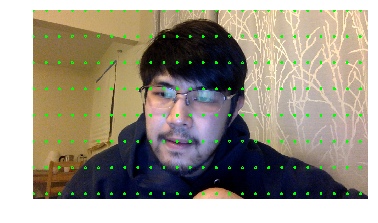

[[[   0    0]]

 [[  50    0]]

 [[ 100    0]]

 [[ 150    0]]

 [[ 200    0]]

 [[ 250    0]]

 [[ 300    0]]

 [[ 350    0]]

 [[ 400    0]]

 [[ 450    0]]

 [[ 500    0]]

 [[ 550    0]]

 [[ 600    0]]

 [[ 650    0]]

 [[ 700    0]]

 [[ 750    0]]

 [[ 800    0]]

 [[ 850    0]]

 [[ 900    0]]

 [[ 950    0]]

 [[1000    0]]

 [[1050    0]]

 [[1100    0]]

 [[1150    0]]

 [[1200    0]]

 [[1250    0]]

 [[   0  100]]

 [[  50  100]]

 [[ 100  100]]

 [[ 150  100]]

 [[ 200  100]]

 [[ 250  100]]

 [[ 300  100]]

 [[ 350  100]]

 [[ 400  100]]

 [[ 450  100]]

 [[ 500  100]]

 [[ 550  100]]

 [[ 600  100]]

 [[ 650  100]]

 [[ 700  100]]

 [[ 750  100]]

 [[ 800  100]]

 [[ 850  100]]

 [[ 900  100]]

 [[ 950  100]]

 [[1000  100]]

 [[1050  100]]

 [[1100  100]]

 [[1150  100]]

 [[1200  100]]

 [[1250  100]]

 [[   0  200]]

 [[  50  200]]

 [[ 100  200]]

 [[ 150  200]]

 [[ 200  200]]

 [[ 250  200]]

 [[ 300  200]]

 [[ 350  200]]

 [[ 400  200]]

 [[ 450  200]]

 [[ 500 

In [309]:
img, points = get_features(frame)
imshow(img)
print points.reshape(-1,1,2)
print points.shape